In [14]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math
from fonctions import *

In [15]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [16]:
def show(coordinates,u):
#
    
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [17]:

def assemblage_triangle(coordinates, elements3, dirichlet, ud, f):
    n = coordinates.shape[0]
    U = np.zeros((n,1))
    
    for sommet in dirichlet:
        vertices = coordinates[sommet][0]
        U[sommet] = ud(vertices[0], vertices[1])
    
    A, b = assemblage_A_et_b(coordinates, elements3, f)
    b = b - A @ U
    
    # l'intérieur de omega 
    interieur = np.setdiff1d(np.arange(len(coordinates)), dirichlet)
    A_int = A[interieur][:,interieur]
    b_int = b[interieur]
    sol = np.linalg.solve(A_int, b_int)
    
    U[interieur] = sol
    
    return A_int, b_int, U
   

**Exemple de problème EDP à résoudre**

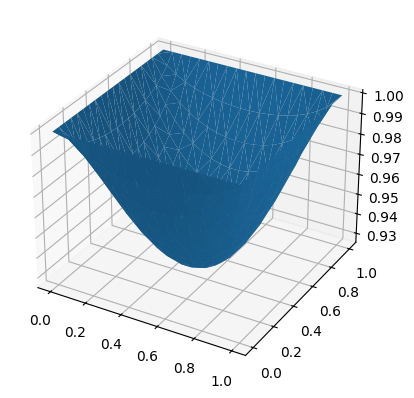

In [18]:

def f(x,y):
    return -1

def u_d(x,y):
    return 1

coordinates, elements3, dirichlet, neumann = maillage(20)
A,b, sol = assemblage_triangle(coordinates, elements3, dirichlet,u_d,f)



sol = sol.flatten()
show(coordinates, sol)

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [19]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [20]:
coordinates = ccs
elements3 = e3
elements4 = e4
dirichlet = dds
neumann = nns

Nt = np.size(e3, 0)
Nq = np.size(e4, 0)
Ns = np.size(ccs, 0)
Nn = np.size(nns, 0)

A = np.zeros((Ns,Ns))
b = np.zeros((Ns,1))
U = np.zeros((Ns,1))


def assemblage_maille_mixte_complete(coordinates, elements3, elements4, dirichlet, neumann, ud, f, g):
    n = coordinates.shape[0]
    U = np.zeros((n, 1))
    
    for i in dirichlet:
        xi, yi = coordinates[i]
        U[i] = ud(xi, yi)
    
    A, b = assemblage_maille_mixte(coordinates, elements3, elements4, f)
    
    for i, j in neumann:
        xi, yi = coordinates[i]
        xj, yj = coordinates[j]
        xm, ym = (xi + xj) / 2, (yi + yj) / 2
        longueur = np.linalg.norm([xi - xj, yi - yj])
        contribution = (longueur / 2) * g(xm, ym)
        b[i] += contribution
        b[j] += contribution
    
    b -= A @ U
    
    interieur = np.setdiff1d(np.arange(n), dirichlet)
    A_int = A[interieur][:, interieur]
    b_int = b[interieur]
    
    sol = np.linalg.solve(A_int, b_int)
    U[interieur] = sol
    
    return A_int, b_int, U




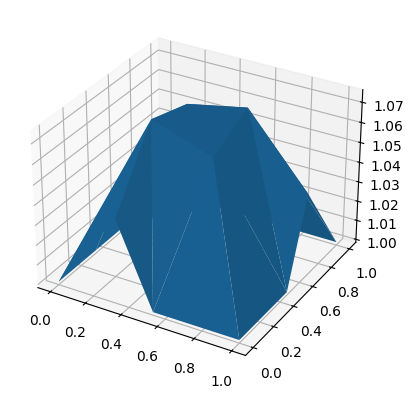

In [21]:
def f(x, y):
    return 1 

def g(x, y):
    return 0

def u_d(x, y):
    return 1

A,b, sol = assemblage_maille_mixte_complete(ccs, e3, e4, dds, nns, u_d, f, g)

sol = sol.flatten()
show(coordinates, sol)

**Compléments  :  un nouveau terme dans l'EDP**